In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import os
import sys
cwd = os.getcwd()
parent_dir = os.path.abspath(os.path.join(cwd, os.pardir))
sys.path.insert(0, os.path.join(parent_dir, 'pysta2'))

import pysta
# import stc
# import stcl

# from stcl import load_centers

import pandas as pd
import os

%load_ext autoreload
%autoreload 2

In [2]:
# helper functions for visualization
def box_off():
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
def p2p(sta):
    return np.max(sta) - np.min(sta)

def psnr(sta):
    return (np.max(sta.ravel()) - np.min(sta.ravel())) / np.std(sta.ravel())

def plot_spatio_temporal(sta, height=13, width=13, dt=1000/30, ylabel=None, fig_basename=None):        
    tap = sta.shape[-1]
    figsize = (5.5,3.5)
    plt.figure(figsize=figsize)
    pysta.plot_temporal_profile(sta, tap, dt, ylim=[-0.5,0.5])
    if ylabel is not None:
        plt.ylabel(ylabel)
    print('peak-to-peak diff. = {:.2f}'.format(p2p(sta)))
    print('PSNR = {:.2f}'.format(psnr(sta)))
#     plt.title('peak diff. = {:.2f}'.format(p2p(sta)))
    plt.xlabel(None)

    if fig_basename is not None:
        plt.savefig(fig_basename + '_temp.pdf', bbox_inches='tight') # https://stackoverflow.com/a/4046233

    plt.figure()
    pysta.plot_stim_slices(sta, height=height, width=width, dt=dt, vmin=-0.5, vmax=0.5)

#     plt.tight_layout()
    
    if fig_basename is not None:
        plt.savefig(fig_basename + '_spatial.pdf', bbox_inches='tight')
    
    
def groupby_dict(df, col, group):
    data = dict()
    for group_val, d in df.groupby(group):
#         print(group_val)
        data[group_val] = d[col].to_list()
    return data


def plot_bar_by_group(info, col, 
                      groupby='cell_type', 
                      group_values = ['ON', 'OFF', 'ON-OFF', 'Unknown'], color=['r','#00A0FF','green', '#A0A0A0']):
    
    means = info.groupby(groupby)[col].mean()[group_values]
    sems = info.groupby(groupby)[col].sem()[group_values]

    plt.bar(group_values, means, yerr=sems,
            width=0.4, color=color, edgecolor='k', linewidth=1,
            capsize=5)
    
    plt.ylabel(col)
    plt.xlabel('cell type')
    
    plt.xlim(-0.5, len(group_values)-0.5)
    box_off()

Let's re-plot old Figure 3 (ON-OFF cell) for all the methods

## load data

In [3]:
data_path = 'data'

dataset = '20201209'
width = 26
height = 26

dataset = '20201216'
width = 13
height = 13

# dataset = '20180626'
# width = 8
# height = 8

In [4]:
# different spatial & temporal resolutions (2018.08.28)
data_path = 'data'

width = 8
height = 8
fps = 10

width = 8
height = 8
fps = 25

width = 13
height = 13
fps = 10

width = 26
height = 26
fps = 10

dataset = '20180828_{}pix_{}Hz'.format(width,fps)
dataset

'20180828_26pix_10Hz'

In [5]:
info = pd.read_csv(os.path.join(data_path, dataset + '_info.csv'))
data = np.load(os.path.join(data_path, dataset + '.npz'))

stim = data['stim'] - 0.5
spike_counts = data['spike_counts']

len(info)

108

## calc STA for an RGC

In [6]:
print(stim.shape)
print(spike_counts.shape)

(9000, 676)
(108, 9000)


In [7]:
# choose a channel
ch_idx = 12
# ch_idx = 103  # ON
# ch_idx = 81   # Unknown   # only 3 spikes

# 26x26
# ch_idx = 22   # 33c	ON
# ch_idx = 29   # 37b ON
# ch_idx = 41     # 48b OFF
ch_idx = 67     # 71c ON  (p2p=0.4)


# small p2p
# ch_idx = 81  #85b ON-OFF
#ch_idx = 84 #87b ON

channel_name = info['channel'][ch_idx]
cell_types = info['cell_type'][ch_idx]
print(channel_name, cell_types)

45a Unknown


(235, 676, 8)
peak-to-peak diff. = 0.23
PSNR = 6.57


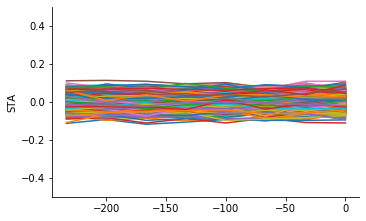

<Figure size 432x288 with 0 Axes>

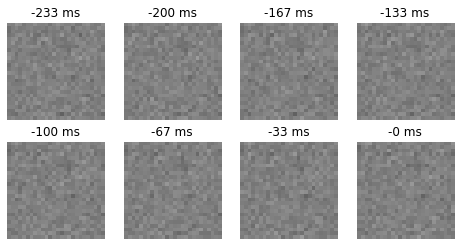

In [8]:
if fps == 10:
    tap = 8
elif fps == 25:
    tap = 20

spike_triggered_stim, weights = pysta.grab_spike_triggered_stim(stim, spike_counts[ch_idx], tap=tap)

sta = np.average(spike_triggered_stim, weights=weights, axis=0)
# sta.shape

print(spike_triggered_stim.shape)


import os
if not os.path.exists(os.path.join('figure', 'sta')):
    os.makedirs(os.path.join('figure', 'sta'))
    
plot_spatio_temporal(sta, 
                     width=width, height=height,
                     ylabel='STA',
                     fig_basename=os.path.join('figure', 'sta', channel_name))
# plt.title(channel_name + '(%.2f)'.format)

## calc STA and peak-to-peak difference for all RGCs

In [9]:
# choose a channel
sta_p2ps = []
sta_psnrs = []

for ch_idx in range(spike_counts.shape[0]):

    channel_name = info['channel'][ch_idx]
    cell_types = info['cell_type'][ch_idx]
    print(channel_name, cell_types)
    

    spike_triggered_stim, weights = pysta.grab_spike_triggered_stim(stim, spike_counts[ch_idx], tap=tap)

    sta = np.average(spike_triggered_stim, weights=weights, axis=0)
    # sta.shape
    
    sta_p2ps.append(p2p(sta))
    sta_psnrs.append(psnr(sta))

#     print(spike_triggered_stim.shape)

#     plot_spatio_temporal(sta, ylabel='STA') #, 
#     #                     fig_basename=os.path.join('figure', 'sta', channel_name))
#     # plt.title(channel_name + '(%.2f)'.format)

info['sta_p2p'] = sta_p2ps
info['sta_psnr'] = sta_psnrs

info.to_csv(dataset + '_sta.csv', index=None)

12a OFF
12b Unknown
12c ON
12d OFF
12e ON
13a OFF
13b Unknown
13c ON
13d ON
14a ON
14b ON
14c Unknown
14d ON
16a OFF
22a ON
22b OFF
23a Unknown
23b ON
23c ON
23d ON
24a Unknown
24b OFF
24c ON
24d ON
25a Unknown
25b OFF
25c ON
25d ON
27a OFF
27b ON
27c ON
27d OFF
27e Unknown
28a OFF
28b Unknown
28c ON
31a OFF
31b ON
31c ON
31d Unknown
32a OFF
32b OFF
32c OFF
32d OFF
32e OFF
32f OFF
32g OFF
32h OFF
33a OFF
33b OFF
33c ON
36a OFF
36b ON
36c OFF
36d ON
36e ON
36f Unknown
37a Unknown
37b Unknown
37c ON
37d Unknown
37e Unknown
41a Unknown
41b ON
41c ON
42a OFF
42b OFF
45a Unknown
46a Unknown
46b Unknown
47a OFF
47b Unknown
48a OFF
48b Unknown
48c Unknown
51a OFF
51b Unknown
51c ON
51d ON
52a Unknown
52b ON
53a OFF
54a Unknown
57a Unknown
57b Unknown
61a ON
61b Unknown
61c Unknown
61d Unknown
62a Unknown
62b ON
63a OFF
63b Unknown
64a Unknown
67a Unknown
67b Unknown
72a Unknown
73a Unknown
73b Unknown
76a Unknown
82a Unknown
82b Unknown
83a Unknown
83b Unknown
84a Unknown
86a Unknown
86b Unkn

## analyze results

In [10]:
# # dataset = '20201209'
# # info = pd.read_csv('20201209_sta.csv')

# dataset = '20201216'
# info = pd.read_csv('20201216_sta.csv')


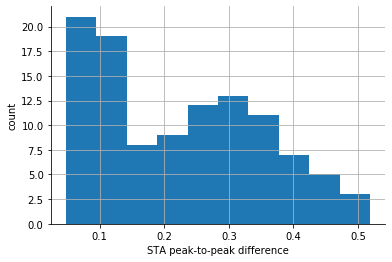

In [11]:
info['sta_p2p'].hist()
plt.xlabel('STA peak-to-peak difference')
plt.ylabel('count')
box_off()

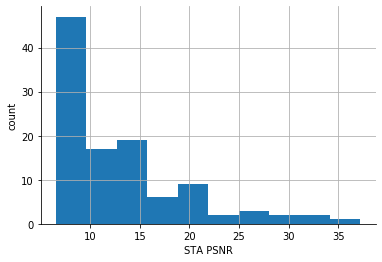

In [12]:
info['sta_psnr'].hist()
plt.xlabel('STA PSNR')
plt.ylabel('count')
box_off()

In [13]:
idx_high_snr = info['sta_p2p'] >= 0.3
info[idx_high_snr]

,channel,cell_type,sta_p2p,sta_psnr
2,12c,ON,0.317390,20.802076
4,12e,ON,0.301205,17.429026
12,14d,ON,0.507389,13.558402
21,24b,OFF,0.388068,37.231880
22,24c,ON,0.358323,21.435426
23,24d,ON,0.392079,15.382873
28,27a,OFF,0.366420,33.580716
29,27b,ON,0.519097,29.703993
30,27c,ON,0.331967,20.706045
31,27d,OFF,0.409310,19.745580


In [14]:
if len(info['cell_type'].value_counts()) == 3: # ON, OFF, Unknown
    group_values = ['ON', 'OFF', 'Unknown']
    color=['r','#00A0FF', '#A0A0A0']
elif len(info['cell_type'].value_counts()) == 4: # ON, OFF, ON-OFF, Unknown
    group_values = ['ON', 'OFF', 'ON-OFF', 'Unknown']
    color=['r','#00A0FF','green', '#A0A0A0']    

In [15]:
info.groupby('cell_type', sort=False).mean()

,sta_p2p,sta_psnr
cell_type,,
OFF,0.273742,19.450459
Unknown,0.182232,7.967625
ON,0.245490,14.021655


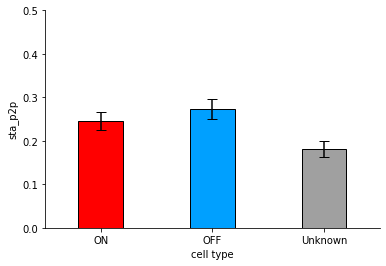

In [16]:
plot_bar_by_group(info, 'sta_p2p',
                  group_values = group_values, color=color)

plt.ylim(0, 0.5)
plt.savefig("figure/sta/{}_p2p_bar.pdf".format(dataset), bbox_inches='tight')
plt.savefig("figure/sta/{}_p2p_bar.png".format(dataset), bbox_inches='tight')

In [17]:
# test significance: ON or OFF vs. ON/OFF
data = groupby_dict(info, 'sta_p2p', 'cell_type')

t, p = stats.ttest_ind(data['ON'], data['OFF'], equal_var=False)
print(p)

t, p = stats.ttest_ind(data['ON'] + data['OFF'], data['Unknown'], equal_var=False)
print(p)

0.3527657703368968
0.0016858513634830927


In [18]:
idx_high_snr = info['sta_psnr'] >= 8
info[idx_high_snr]

,channel,cell_type,sta_p2p,sta_psnr
0,12a,OFF,0.254622,20.244346
1,12b,Unknown,0.083526,9.877785
2,12c,ON,0.317390,20.802076
3,12d,OFF,0.266202,19.472688
4,12e,ON,0.301205,17.429026
...,...,...,...,...
85,61a,ON,0.132921,8.121701
90,62b,ON,0.107822,10.173421
91,63a,OFF,0.426025,15.095842
94,67a,Unknown,0.322981,8.001264


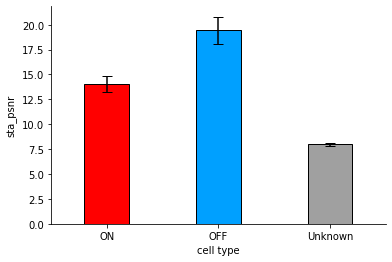

In [19]:
plot_bar_by_group(info, 'sta_psnr',
                  group_values = group_values, color=color)

plt.savefig("figure/sta/{}_psnr_bar.pdf".format(dataset), bbox_inches='tight')
plt.savefig("figure/sta/{}_psnr_bar.png".format(dataset), bbox_inches='tight')

In [20]:
# test significance: ON or OFF vs. ON/OFF
data = groupby_dict(info, 'sta_psnr', 'cell_type')

t, p = stats.ttest_ind(data['ON'], data['OFF'], equal_var=False)
print(p)

t, p = stats.ttest_ind(data['ON'] + data['OFF'], data['Unknown'], equal_var=False)
print(p)

0.0011428480822921884
4.6740781196538155e-15
